# Standard Imports

In [1]:
#COLAB=True # toggle accordingly
COLAB=False
if COLAB:
    import numpy as np
    print (np.__version__)
    !pip install numpy==1.15.4 # to avoid bug loading hdf file "ValueError: cannot set WRITEABLE flag to True of this array"
    print (np.__version__)


In [2]:
#### Reading file from Google Drive
if COLAB:
    !pip install PyDrive
    import os
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

In [7]:
if COLAB:
    # download dataset 
    #directory download = drive.CreateFile({'id': '1TuvyEky9lCcc5ybC6nTl5zzkIm8p8AVO'})
    #download.GetContentFile("dataWW")

    #download three file 
    download = drive.CreateFile({'id': '1RN6BVBH4A3v_BBKguiEDJQ2z_pLNWHL_'})
    download.GetContentFile("dataWW_qq.hdf")
    download = drive.CreateFile({'id': '12kRnrvsluiBvXqvNOk2lb0Agna13lSzV'})
    download.GetContentFile("dataWW_ggH.hdf")
    download = drive.CreateFile({'id': '1nsGp13Mw3CzjtON---j1cWQziuFpkoEp'})
    download.GetContentFile("dataWW_VBFH.hdf")
    
    !ls -lrt
    datapath=""
else:
    datapath="/Users/rousseau/Google Drive/GD_ST4Perso/CoursML/TDML/dataWW/"
    

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from IPython import display
from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed

#!pip install pytables # to read hdf5
#!pip install xgboost
#!pip install lightgbm # not sure it loads the .so
#!conda install --yes lightgbm # better run in separate window

In [9]:
# some utilities
from math import sqrt
from math import log


def amsasimov(s,b): # asimove significance
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

#
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30, xlabel="", ylabel="Arbitrary units", title="", weights_train=np.array([]), weights_test=np.array([])):
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', normed=True,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, normed=True, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, normed=True, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')


In [10]:
#load signal, background data
#more info on dataset http://opendata.atlas.cern/books/current/openatlasdatatools/_book/simulated_data_details.html
# dataset ID qq : 105985, ggH : 160155, vbfh : 160205
# cross section  qq: 12.42 pb, ggH: 13.17 pb , VBFH : 1.617 pb
# unfortunately cross section in the document are wrong
qq_cross_section=1242 # deliberately wrong to increase background level
ggh_cross_section=13.17*0.5 # deliberately wrong to 
vbfh_cross_section=1.617*0.5 # deliberately wrong to 



# total integrated luminosity ATLAS 2012 : fb^-1
luminosity=21 
# even more info in http://opendata.atlas.cern/books/current/openatlasdatatools/_book/glossary.html 

#if fail to load, might be due to numpy version, see first cell
qq_events = pd.read_hdf(datapath+"dataWW_qq.hdf","qq",WRITEABLE=False ) #quarks (qq background) http://opendata.cern.ch/record/3800
ggh_events = pd.read_hdf(datapath+"dataWW_ggH.hdf","ggH",WRITEABLE=False ) # gluons fusion http://opendata.cern.ch/record/3825
vbfh_events = pd.read_hdf(datapath+"dataWW_VBFH.hdf","VBFH",WRITEABLE=False ) #Vector Boson Fusion http://opendata.cern.ch/record/3826
vbfh_events.columns


Index(['runNumber', 'eventNumber', 'channelNumber', 'mcWeight', 'pvxp_n',
       'vxp_z', 'scaleFactor_PILEUP', 'scaleFactor_ELE', 'scaleFactor_MUON',
       'scaleFactor_BTAG', 'scaleFactor_TRIGGER', 'scaleFactor_JVFSF',
       'scaleFactor_ZVERTEX', 'trigE', 'trigM', 'passGRL', 'hasGoodVertex',
       'met_et', 'met_phi', 'jet_n', 'alljet_n', 'lep_n', 'jet_pt_0',
       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1',
       'jet_E_0', 'jet_E_1', 'jet_m_0', 'jet_m_1', 'jet_jvf_0', 'jet_jvf_1',
       'jet_trueflav_0', 'jet_trueflav_1', 'jet_truthMatched_0',
       'jet_truthMatched_1', 'jet_SV0_0', 'jet_SV0_1', 'jet_MV1_0',
       'jet_MV1_1', 'lep_truthMatched_0', 'lep_truthMatched_1',
       'lep_trigMatched_0', 'lep_trigMatched_1', 'lep_pt_0', 'lep_pt_1',
       'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1', 'lep_E_0',
       'lep_E_1', 'lep_z0_0', 'lep_z0_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'lep_flag_0', 'lep_flag_1',
       

# load signal, background data

In [11]:
nvbfkeep=int(ggh_events.shape[0]*0.1232)
print ("keep only ",nvbfkeep, " vbfh events to respect vbf H/ gg H ratio")
vbfh_events=vbfh_events[0:nvbfkeep]


qq_events["class"] = 0   # background category
ggh_events["class"] = 1  # signal category
vbfh_events["class"] = 1  # signal category
h_events = pd.concat([ggh_events, vbfh_events]) # merge the two higgs dataset
del ggh_events  # avoid mistakes later
del vbfh_events  # avoid mistakes later

keep only  12320  vbfh events to respect vbf H/ gg H ratio


In [12]:
h_events.describe()

,runNumber,eventNumber,channelNumber,mcWeight,pvxp_n,vxp_z,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_BTAG,scaleFactor_TRIGGER,scaleFactor_JVFSF,scaleFactor_ZVERTEX,met_et,met_phi,jet_n,alljet_n,lep_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,jet_m_0,jet_m_1,jet_jvf_0,jet_jvf_1,jet_trueflav_0,jet_trueflav_1,jet_truthMatched_0,jet_truthMatched_1,jet_SV0_0,jet_SV0_1,jet_MV1_0,jet_MV1_1,lep_trigMatched_0,lep_trigMatched_1,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_z0_0,lep_z0_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,lep_flag_0,lep_flag_1,lep_ptcone30_0,lep_ptcone30_1,lep_etcone20_0,lep_etcone20_1,lep_trackd0pvunbiased_0,lep_trackd0pvunbiased_1,lep_tracksigd0pvunbiased_0,lep_tracksigd0pvunbiased_1,class
count,112320.0,112320.000000,112320.000000,112320.0,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.0,112320.000000,1.123200e+05,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,1.123200e+05,1.123200e+05,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,1.123200e+05,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,1.123200e+05,1.123200e+05,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.000000,112320.0
mean,195847.0,237787.722543,161010.484330,1.0,13.457265,-6.139131,1.045671,0.963257,0.999136,1.000420,0.992656,1.0,0.999227,5.349065e+04,-0.046005,0.719462,0.892210,1.744774,35248.020900,8570.722804,-434.934734,-775.855789,-434.942633,-775.852416,7.801489e+04,2.030726e+04,4759.927352,778.535297,-434.499207,-775.705802,-434.728196,-775.765064,-434.431668,-775.674608,-434.728486,-775.799822,-434.874301,-775.829708,1.676656,-260.604505,43448.686939,13906.309070,0.005476,-260.792760,0.038229,-260.781534,8.210047e+04,25973.870255,-0.000172,-260.797043,0.001246,-260.794391,11.994623,-251.833832,4.631537e+08,1.178083e+08,1238.194540,700.590366,1154.020660,397.674182,0.001231,-260.796019,0.019180,-260.777207,1.0
std,0.0,143477.781863,15.625006,0.0,5.239623,65.291618,0.701782,0.040245,0.006574,0.028514,0.050940,0.0,0.361807,3.160024e+04,1.811829,0.918370,1.023448,0.449444,48826.625776,20831.458508,495.314874,416.084769,495.308768,416.091445,1.273903e+05,5.567906e+04,6659.241399,3633.747730,495.696343,416.363990,495.496415,416.254288,495.755646,416.422160,495.505136,416.191389,495.366928,416.132918,0.985940,438.888556,18616.483136,12478.528844,1.189634,438.777514,1.821123,438.785802,5.875869e+04,29198.620693,0.124570,438.773826,1.000004,438.776226,0.999990,444.102188,1.302232e+08,1.355787e+08,8030.056558,7601.101632,2255.243505,2745.715917,0.039400,438.774421,0.009536,438.785598,0.0
min,195847.0,5.000000,161005.000000,1.0,1.000000,-247.911148,0.000000,0.705812,0.884338,0.751338,0.687731,1.0,0.000000,7.472369e+01,-3.141591,0.000000,0.000000,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-9.990000e+02,-9.990000e+02,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,-999.000000,25000.894531,-999.000000,-2.499078,-999.000000,-3.141546,-999.000000,2.500937e+04,-999.000000,-1.974075,-999.000000,-1.000000,-999.000000,11.000000,-999.000000,2.694900e+08,-9.990000e+02,0.000000,-999.000000,-6519.972656,-45141.285156,-1.818148,-999.000000,0.006365,-999.000000,1.0
25%,195847.0,112864.000000,161005.000000,1.0,10.000000,-50.428758,0.310830,0.939916,0.998074,0.997714,0.981765,1.0,0.771907,3.320963e+04,-1.609891,0.000000,0.000000,1.000000,-999.000000,-999.0

In [13]:
h_events.head()

,runNumber,eventNumber,channelNumber,mcWeight,pvxp_n,vxp_z,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_BTAG,scaleFactor_TRIGGER,scaleFactor_JVFSF,scaleFactor_ZVERTEX,trigE,trigM,passGRL,hasGoodVertex,met_et,met_phi,jet_n,alljet_n,lep_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,jet_m_0,jet_m_1,jet_jvf_0,jet_jvf_1,jet_trueflav_0,jet_trueflav_1,jet_truthMatched_0,jet_truthMatched_1,jet_SV0_0,jet_SV0_1,jet_MV1_0,jet_MV1_1,lep_truthMatched_0,lep_truthMatched_1,lep_trigMatched_0,lep_trigMatched_1,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_z0_0,lep_z0_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,lep_flag_0,lep_flag_1,lep_ptcone30_0,lep_ptcone30_1,lep_etcone20_0,lep_etcone20_1,lep_trackd0pvunbiased_0,lep_trackd0pvunbiased_1,lep_tracksigd0pvunbiased_0,lep_tracksigd0pvunbiased_1,class
0,195847,15002,161005,1.0,10,-45.141529,2.186532,0.930299,0.998568,1.000000,0.999568,1.0,1.202204,True,True,True,True,61586.476562,-0.426936,0,0,2,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,True,True,1,1.0,31170.814453,30254.810547,2.220283,1.732800,-2.001617,2.647304,145232.859375,88242.148438,0.059327,0.082366,-1.0,1.0,11,13.0,550524927,31473663.0,3612.388672,0.0,2295.938721,116.179558,-0.014627,0.006217,0.032921,0.017847,1
1,195847,15015,161005,1.0,9,-13.072186,2.186532,0.945472,0.999277,0.998096,0.998372,1.0,1.365181,True,True,True,True,46467.925781,0.737008,1,1,2,25362.882812,-999.000000,1.053382,-999.000000,1.932577,-999.000000,40920.964844,-999.000000,3337.618896,-999.000000,1.000000,-999.000000,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.060746,-999.000000,True,True,1,1.0,33547.414062,28001.335938,-0.429499,-0.123097,-2.162361,-1.325787,36689.511719,28213.953125,-0.011544,0.070305,-1.0,1.0,11,13.0,567304191,31473663.0,0.000000,0.0,-1338.239258,791.379822,0.010789,-0.000287,0.015672,0.013690,1
2,195847,15017,161005,1.0,7,-46.711895,2.186532,0.871060,1.000000,1.000000,0.994758,1.0,1.189022,True,False,True,True,44978.320312,-1.319276,0,0,2,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,True,True,1,0.0,36994.914062,11795.859375,1.018005,0.429071,1.371667,2.256000,57878.234375,12898.438477,0.028692,-0.032200,-1.0,1.0,11,11.0,298868735,290480127.0,0.000000,0.0,3001.633789,359.652466,0.003421,0.014644,0.020231,0.037425,1
3,195847,15022,161005,1.0,9,-31.384344,2.186532,0.911373,0.999423,1.000000,0.975483,1.0,1.303636,False,True,True,True,31986.681641,-2.335214,0,0,2,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.000000,True,True,1,0.0,29190.964844,13348.142578,0.643155,-0.039744,1.450079,0.518985,35439.523438,13358.686523,-0.035249,0.028219,-1.0,1.0,13,11.0,568344575,5266943.0,0.000000,0.0,96.588013,1460.436646,-0.027695,-0.173611,0.018773,0.051919,1
4,195847,15023,161005,1.0,12,24.167284,2.186532,0.975481,1.000804,0.994616,0.998408,1.0,1.219002,True,True,True,True,50051.781250,-1.137866,2,2,2,99213.234375,36256.121094,2.080407,-0.434997,0.877375,1.768625,403474.500000,40292.753906,5906.834473,6646.506836,0.957225,0.780024,0.0,0.0,1.0,1.0,0.0,0.0,0.055101,0.059921,True,True,1,1.0,58061.281250,28911.482422,1.329880,1.079349,-2.093737,-2.938060,117431.828125,47452.234375,-0.036078,0.061536,1.0,-1.0,11,13.0,550525951,31473663.0,0.000000,0.0,5024.540527,-80.026657,-0.012207,0.016151,0.015775,0.017358,1


In [14]:

vbfh_cross_section=1.617
h_cross_section=ggh_cross_section+vbfh_cross_section


print ("before normalisation")
# in principle should multiply all the scaleFactor (then weights will vary event by event)
class_weights = (qq_events.mcWeight.sum(), h_events.mcWeight.sum()) 
print("total class weights",class_weights)


class_nevents = (len(qq_events.index), len(h_events.index))
print ("total class number of events",class_nevents)

qq_weight=qq_cross_section*luminosity/qq_events.shape[0]*qq_events.mcWeight
qq_events["weight"]=qq_weight
h_weight=h_cross_section*luminosity/h_events.shape[0]*h_events.mcWeight
h_events["weight"]=h_weight

print ("after normalisation")
# in principle should multiply all the scaleFactor (then weights will vary event by event)
total_weights = (qq_events.weight.sum(), h_events.weight.sum()) 

print("total total weights",total_weights)










before normalisation
total class weights (500000.0, 112320.0)
total class number of events (500000, 112320)
after normalisation
total total weights (26081.999999999993, 172.24200000000002)


In [15]:
fulldata = pd.concat([qq_events, h_events]) # merge the datasets
fulldata = fulldata.sample(frac=1).reset_index(drop=True) #shuffle the events
fulldata.head(10)




,runNumber,eventNumber,channelNumber,mcWeight,pvxp_n,vxp_z,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_BTAG,scaleFactor_TRIGGER,scaleFactor_JVFSF,scaleFactor_ZVERTEX,trigE,trigM,passGRL,hasGoodVertex,met_et,met_phi,jet_n,alljet_n,lep_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,jet_m_0,jet_m_1,jet_jvf_0,jet_jvf_1,jet_trueflav_0,jet_trueflav_1,jet_truthMatched_0,jet_truthMatched_1,jet_SV0_0,jet_SV0_1,jet_MV1_0,jet_MV1_1,lep_truthMatched_0,lep_truthMatched_1,lep_trigMatched_0,lep_trigMatched_1,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_z0_0,lep_z0_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,lep_flag_0,lep_flag_1,lep_ptcone30_0,lep_ptcone30_1,lep_etcone20_0,lep_etcone20_1,lep_trackd0pvunbiased_0,lep_trackd0pvunbiased_1,lep_tracksigd0pvunbiased_0,lep_tracksigd0pvunbiased_1,class,weight
0,195847,1064313,105985,1.0,11,37.229420,1.353967,0.965079,1.000000,1.017226,0.992908,1.0,1.097033,True,False,True,True,11966.111328,-2.701330,3,3,1,47973.437500,43337.757812,1.700330,-1.692943,-2.218239,-2.922440,135812.828125,121951.578125,4857.354492,6711.314941,0.835307,0.898409,4.0,0.0,1.0,1.0,0.0,0.0,0.059884,0.055547,True,-999,3,-999.0,78074.898438,-999.000000,-0.960385,-999.000000,0.481870,-999.000000,116934.656250,-999.000000,-0.005333,-999.000000,-1.0,-999.0,11,-999.0,567304191,-999.0,0.000000,-999.000000,4084.899658,-999.000000,-0.004936,-999.000000,0.023381,-999.000000,0,0.052164
1,195847,363822,105985,1.0,9,132.597000,1.910734,0.967795,1.000000,0.997523,1.000458,1.0,0.166754,True,False,True,True,33302.042969,2.263986,1,1,1,61766.882812,-999.000000,-2.188102,-999.000000,1.896692,-999.000000,279041.406250,-999.000000,9196.549805,-999.000000,0.930809,-999.000000,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.057174,-999.000000,True,-999,3,-999.0,66960.710938,-999.000000,-1.397971,-999.000000,-1.565806,-999.000000,143767.234375,-999.000000,-0.030293,-999.000000,-1.0,-999.0,11,-999.0,567304191,-999.0,0.000000,-999.000000,4035.410156,-999.000000,-0.007436,-999.000000,0.023360,-999.000000,0,0.052164
2,195847,1074359,105985,1.0,18,99.197067,0.629896,1.039073,1.000000,0.997886,0.997262,1.0,0.410847,True,False,True,True,67278.609375,0.047651,1,1,1,57355.546875,-999.000000,-0.606960,-999.000000,-2.279974,-999.000000,68761.531250,-999.000000,8381.414062,-999.000000,0.884383,-999.000000,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.058860,-999.000000,True,-999,3,-999.0,81462.757812,-999.000000,-1.361289,-999.000000,1.374366,-999.000000,169342.703125,-999.000000,-0.018874,-999.000000,1.0,-999.0,11,-999.0,567304191,-999.0,0.000000,-999.000000,2642.095703,-999.000000,0.012073,-999.000000,0.019074,-999.000000,0,0.052164
3,195847,2310417,105985,1.0,14,-30.110670,1.353967,1.000000,1.003519,0.995636,1.015840,1.0,1.309219,False,True,True,True,38829.855469,2.968443,2,2,1,60583.078125,26481.464844,-0.675609,-1.602053,-3.073977,1.785543,75716.992188,68491.867188,10794.705078,3836.119385,0.895587,0.883628,0.0,0.0,1.0,1.0,0.0,0.0,0.056445,0.058015,True,-999,3,-999.0,52443.800781,-999.000000,0.153547,-999.000000,-0.513925,-999.000000,53063.347656,-999.000000,-0.449701,-999.000000,1.0,-999.0,13,-999.0,568344575,-999.0,0.000000,-999.000000,738.197144,-999.000000,0.018282,-999.000000,0.012821,-999.000000,0,0.052164
4,195847,799485,105985,1.0,11,15.466015,1.752262,1.000000,1.000716,1.014430,1.057195,1.0,1.285351,False,True,True,True,25553.056641,-2.248738,2,2,1,45103.578125,29269.429688,1.965677,1.790742,-2.225023,2.111945,164424.250000,90256.843750,9091.670898,4167.947266,0.978156,0.861759,4.0,0.0,1.0,1.0,0.0,0.0,0.054412,0.060490,True,-999,3,-999.0,44989.824219,-999.000000,1.239301,-999.000000,0.392619,-999.000000,84193.664062,-999.000000,-0.023319,-999.000000,1.0,-999.0,13,-999.0,568344575,-999.0,0.000000,-999.000000,59.024666,-999.000000,-0.007600,-999.000000,0.013558,-999.000000,0,0.052164
5,195847,323318,105985,1.0,16,16.927290,0.310830,0.967795,1.000000,1.007024,0.995144,1.0,1.275492,True,Fal

## Event selection

In [16]:
print (fulldata.shape)
fulldata=fulldata[fulldata.lep_n==2]
print (fulldata.shape)



(612320, 72)
(152296, 72)


In [17]:
fulldata.head()

,runNumber,eventNumber,channelNumber,mcWeight,pvxp_n,vxp_z,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_BTAG,scaleFactor_TRIGGER,scaleFactor_JVFSF,scaleFactor_ZVERTEX,trigE,trigM,passGRL,hasGoodVertex,met_et,met_phi,jet_n,alljet_n,lep_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,jet_m_0,jet_m_1,jet_jvf_0,jet_jvf_1,jet_trueflav_0,jet_trueflav_1,jet_truthMatched_0,jet_truthMatched_1,jet_SV0_0,jet_SV0_1,jet_MV1_0,jet_MV1_1,lep_truthMatched_0,lep_truthMatched_1,lep_trigMatched_0,lep_trigMatched_1,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_z0_0,lep_z0_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,lep_flag_0,lep_flag_1,lep_ptcone30_0,lep_ptcone30_1,lep_etcone20_0,lep_etcone20_1,lep_trackd0pvunbiased_0,lep_trackd0pvunbiased_1,lep_tracksigd0pvunbiased_0,lep_tracksigd0pvunbiased_1,class,weight
6,195847,254161,161005,1.0,14,-55.335182,0.197909,0.944407,1.005214,0.996960,0.993845,1.0,1.107445,True,False,True,True,50800.632812,2.579927,1,1,2,25012.109375,-999.0,-1.304783,-999.0,1.325655,-999.0,49607.703125,-999.0,3259.720459,-999.0,0.952135,-999.0,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.057127,-999.0,True,True,0,1.0,34163.761719,29709.898438,0.730013,0.873548,-1.252535,-2.367543,43678.679688,41784.941406,0.109938,-0.117824,-1.0,1.0,13,11.0,559955967,30433279.0,0.000000,1208.937866,734.411438,1800.270508,0.057428,0.014925,0.016449,0.023106,1,0.001533
7,195847,36334,161005,1.0,12,-100.495407,1.752262,1.000000,0.995739,0.998393,0.902730,1.0,0.588388,False,True,True,True,13186.167969,2.927826,1,1,2,67816.890625,-999.0,-1.159312,-999.0,-1.655137,-999.0,119183.429688,-999.0,10404.831055,-999.0,0.971806,-999.0,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.527896,-999.0,True,True,3,0.0,69083.484375,12156.409180,0.081423,-1.111583,1.297612,0.530154,69312.695312,20472.894531,0.082230,0.065529,1.0,-1.0,13,13.0,299909119,274735103.0,0.000000,0.000000,-29.582935,183.128738,0.006907,-0.001382,0.010447,0.017175,1,0.001533
18,195847,160380,161055,1.0,5,-127.972969,1.099592,0.910764,0.996255,0.998151,0.949741,1.0,0.326956,False,True,True,True,81179.578125,-1.566029,1,1,2,90746.437500,-999.0,-0.395733,-999.0,2.189070,-999.0,99739.117188,-999.0,18831.011719,-999.0,1.000000,-999.0,0.0,-999.0,1.0,-999.0,0.0,-999.0,0.054857,-999.0,True,True,1,0.0,25341.910156,10289.421875,0.915681,0.449605,-2.815974,-0.601968,36729.707031,11347.032227,-0.049821,-0.045554,1.0,-1.0,13,11.0,568344575,5266431.0,0.000000,0.000000,-172.191498,2541.164551,-0.003926,0.003620,0.019238,0.027334,1,0.001533
25,195847,1815572,105985,1.0,15,-39.109585,1.138577,0.901008,1.000000,1.000000,1.000008,1.0,1.250711,True,False,True,True,23688.367188,2.012927,0,0,2,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,True,True,1,0.0,33515.347656,24991.931641,0.264335,0.962191,0.940547,-1.055411,34693.085938,37481.386719,-0.010365,0.038889,-1.0,1.0,11,11.0,282089471,290480127.0,1636.822144,619.381348,452.723602,-398.738647,-0.028595,0.013385,0.017593,0.017836,0,0.052164
27,195847,1279940,105985,1.0,26,9.235197,0.000000,1.000000,0.997528,1.000000,0.970863,1.0,1.319560,False,True,True,True,46619.207031,2.716373,0,0,2,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.000000,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.000000,-999.0,True,True,3,3.0,226937.687500,164183.000000,0.468807,-0.278315,-0.272390,2.982163,252335.968750,170582.921875,0.082724,-0.042965,1.0,-1.0,13,13.0,299909119,299909119.0,0.000000,0.000000,631.217712,851.117859,-0.007134,-0.008781,0.007667,0.007756,0,0.052164


In [18]:
#DR replace dummy -999 by -10 because of XGboost hist bug
fulldata.replace(-999,-7,inplace=True)
fulldata.head()

,runNumber,eventNumber,channelNumber,mcWeight,pvxp_n,vxp_z,scaleFactor_PILEUP,scaleFactor_ELE,scaleFactor_MUON,scaleFactor_BTAG,scaleFactor_TRIGGER,scaleFactor_JVFSF,scaleFactor_ZVERTEX,trigE,trigM,passGRL,hasGoodVertex,met_et,met_phi,jet_n,alljet_n,lep_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,jet_m_0,jet_m_1,jet_jvf_0,jet_jvf_1,jet_trueflav_0,jet_trueflav_1,jet_truthMatched_0,jet_truthMatched_1,jet_SV0_0,jet_SV0_1,jet_MV1_0,jet_MV1_1,lep_truthMatched_0,lep_truthMatched_1,lep_trigMatched_0,lep_trigMatched_1,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_z0_0,lep_z0_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,lep_flag_0,lep_flag_1,lep_ptcone30_0,lep_ptcone30_1,lep_etcone20_0,lep_etcone20_1,lep_trackd0pvunbiased_0,lep_trackd0pvunbiased_1,lep_tracksigd0pvunbiased_0,lep_tracksigd0pvunbiased_1,class,weight
6,195847,254161,161005,1.0,14,-55.335182,0.197909,0.944407,1.005214,0.996960,0.993845,1.0,1.107445,True,False,True,True,50800.632812,2.579927,1,1,2,25012.109375,-7.0,-1.304783,-7.0,1.325655,-7.0,49607.703125,-7.0,3259.720459,-7.0,0.952135,-7.0,0.0,-7.0,1.0,-7.0,0.0,-7.0,0.057127,-7.0,True,True,0,1.0,34163.761719,29709.898438,0.730013,0.873548,-1.252535,-2.367543,43678.679688,41784.941406,0.109938,-0.117824,-1.0,1.0,13,11.0,559955967,30433279.0,0.000000,1208.937866,734.411438,1800.270508,0.057428,0.014925,0.016449,0.023106,1,0.001533
7,195847,36334,161005,1.0,12,-100.495407,1.752262,1.000000,0.995739,0.998393,0.902730,1.0,0.588388,False,True,True,True,13186.167969,2.927826,1,1,2,67816.890625,-7.0,-1.159312,-7.0,-1.655137,-7.0,119183.429688,-7.0,10404.831055,-7.0,0.971806,-7.0,0.0,-7.0,1.0,-7.0,0.0,-7.0,0.527896,-7.0,True,True,3,0.0,69083.484375,12156.409180,0.081423,-1.111583,1.297612,0.530154,69312.695312,20472.894531,0.082230,0.065529,1.0,-1.0,13,13.0,299909119,274735103.0,0.000000,0.000000,-29.582935,183.128738,0.006907,-0.001382,0.010447,0.017175,1,0.001533
18,195847,160380,161055,1.0,5,-127.972969,1.099592,0.910764,0.996255,0.998151,0.949741,1.0,0.326956,False,True,True,True,81179.578125,-1.566029,1,1,2,90746.437500,-7.0,-0.395733,-7.0,2.189070,-7.0,99739.117188,-7.0,18831.011719,-7.0,1.000000,-7.0,0.0,-7.0,1.0,-7.0,0.0,-7.0,0.054857,-7.0,True,True,1,0.0,25341.910156,10289.421875,0.915681,0.449605,-2.815974,-0.601968,36729.707031,11347.032227,-0.049821,-0.045554,1.0,-1.0,13,11.0,568344575,5266431.0,0.000000,0.000000,-172.191498,2541.164551,-0.003926,0.003620,0.019238,0.027334,1,0.001533
25,195847,1815572,105985,1.0,15,-39.109585,1.138577,0.901008,1.000000,1.000000,1.000008,1.0,1.250711,True,False,True,True,23688.367188,2.012927,0,0,2,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.000000,-7.0,True,True,1,0.0,33515.347656,24991.931641,0.264335,0.962191,0.940547,-1.055411,34693.085938,37481.386719,-0.010365,0.038889,-1.0,1.0,11,11.0,282089471,290480127.0,1636.822144,619.381348,452.723602,-398.738647,-0.028595,0.013385,0.017593,0.017836,0,0.052164
27,195847,1279940,105985,1.0,26,9.235197,0.000000,1.000000,0.997528,1.000000,0.970863,1.0,1.319560,False,True,True,True,46619.207031,2.716373,0,0,2,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.000000,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.0,-7.000000,-7.0,True,True,3,3.0,226937.687500,164183.000000,0.468807,-0.278315,-0.272390,2.982163,252335.968750,170582.921875,0.082724,-0.042965,1.0,-1.0,13,13.0,299909119,299909119.0,0.000000,0.000000,631.217712,851.117859,-0.007134,-0.008781,0.007667,0.007756,0,0.052164


In [19]:
#hide class in separate vector
#WARNING : there should be no selection nor shuffling later on !
target = fulldata["class"]
del fulldata["class"]

#hide weight in separate vector
weights = fulldata["weight"]
del fulldata["weight"]
fulldata.shape

(152296, 70)

# DO NOT MODIFY ANYTHING ABOVE

In [20]:
# always rerun exercises from this cell
# for simplicity of the exercise only keep some features
data=fulldata[["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1','jet_n','jet_eta_0', 'jet_eta_1']]
#data=fulldata[["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1']]
print (data.shape)
data.head()




(152296, 9)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1,jet_n,jet_eta_0,jet_eta_1
6,50800.632812,2.579927,34163.761719,29709.898438,-1.252535,-2.367543,1,-1.304783,-7.0
7,13186.167969,2.927826,69083.484375,12156.409180,1.297612,0.530154,1,-1.159312,-7.0
18,81179.578125,-1.566029,25341.910156,10289.421875,-2.815974,-0.601968,1,-0.395733,-7.0
25,23688.367188,2.012927,33515.347656,24991.931641,0.940547,-1.055411,0,-7.000000,-7.0
27,46619.207031,2.716373,226937.687500,164183.000000,-0.272390,2.982163,0,-7.000000,-7.0


<Figure size 432x288 with 0 Axes>

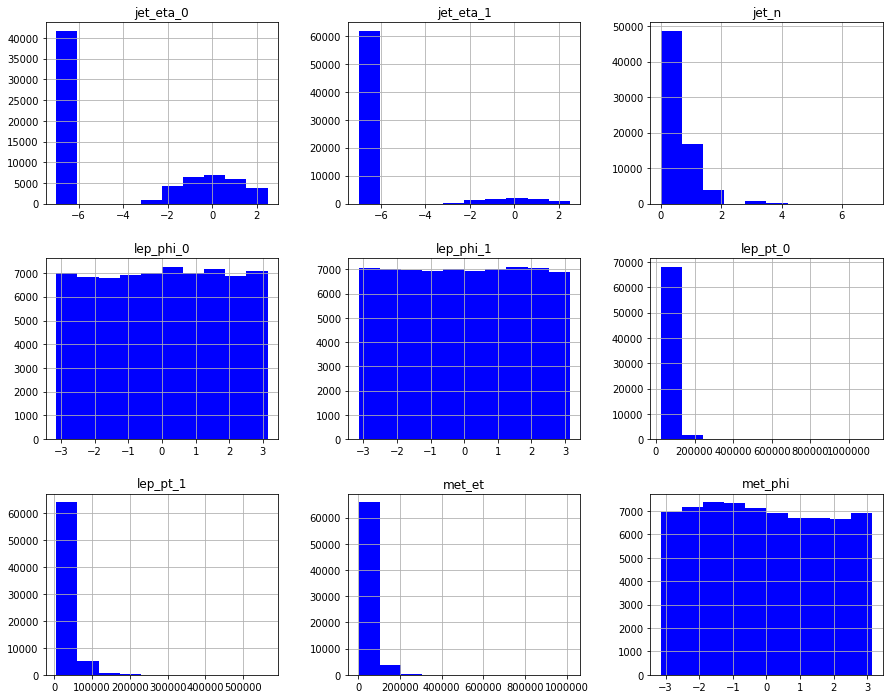

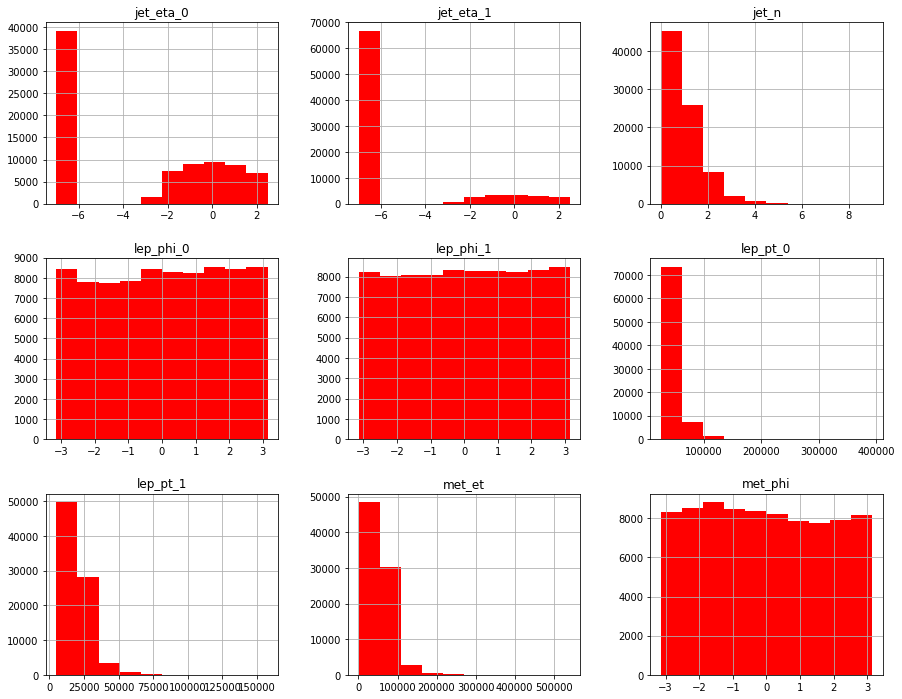

In [21]:
plt.figure()

data[target==0].hist(figsize=(15,12),color='b')
data[target==1].hist(figsize=(15,12),color='r')

plt.show()

# Feature engineering

In [22]:

#data["lep_deltaphi"]=np.abs(np.mod(data["lep_phi_0"]-data["lep_phi_1"]+3*np.pi,2*np.pi)-np.pi)
#data["lep_deltaphi"]=data["lep_phi_0"]-data["lep_phi_1"]

print (data.shape)
data.head()



(152296, 9)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1,jet_n,jet_eta_0,jet_eta_1
6,50800.632812,2.579927,34163.761719,29709.898438,-1.252535,-2.367543,1,-1.304783,-7.0
7,13186.167969,2.927826,69083.484375,12156.409180,1.297612,0.530154,1,-1.159312,-7.0
18,81179.578125,-1.566029,25341.910156,10289.421875,-2.815974,-0.601968,1,-0.395733,-7.0
25,23688.367188,2.012927,33515.347656,24991.931641,0.940547,-1.055411,0,-7.000000,-7.0
27,46619.207031,2.716373,226937.687500,164183.000000,-0.272390,2.982163,0,-7.000000,-7.0


## Transformation of the features

In [23]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # fraction of sample used for training
X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)
#reset index for dataseries, not needed for ndarray (X_train, X_test)
y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)
print (X_train.shape)
print (y_train.shape)
print (weights_train.shape)
print (X_test.shape)
print (y_test.shape)
print (weights_test.shape)





#scale to mean 0 and variance 1
scaler = StandardScaler()
#scaler.fit(data)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # applied the transformation calculated the line above


class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_train == i] *= 1/(1-train_size) # increase test weight to compensate for sampling
    
print ("Test : total weight bkg", weights_test[y_test == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())
print ("Train : total weight sig", weights_train[y_train == 1].sum())



    


(114222, 9)
(114222,)
(114222,)
(38074, 9)
(38074,)
(38074,)
class_weights_train: (2732.193828, 94.83891105769231)
Test : total weight bkg 3664.416672
Test : total weight sig 125.82008205128207
Train : total weight bkg 2732.193828
Train : total weight sig 2732.1938279999995


# Testing NN

## NN

In [25]:
import keras.backend as K
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"

In [27]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
inputs = Input(shape=(X_train.shape[1],))
nnwidth=32
Dx = Dense(nnwidth, activation="relu")(inputs)
#Dx = Dense(nnwidth, activation="relu")(Dx)
#Dx = Dense(nnwidth, activation="relu")(Dx)  # only one layer to save time
Dx = Dense(1, activation="sigmoid")(Dx)
D = Model(input=[inputs], output=[Dx])
D.compile(loss="binary_crossentropy", optimizer="adam")
#HPO number of neurones nnwidth, activation function, etc.... check on the web

starting_time = time.time( )
D.fit(X_train, y_train.values, epochs=10, verbose=0, class_weight=class_weights)
training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_keras = D.predict(X_test)
y_pred_keras = y_pred_keras.ravel()
y_pred_train_keras = D.predict(X_train).ravel()
auc_test_keras = roc_auc_score(y_true=y_test, y_score=y_pred_keras)
auc_train_keras = roc_auc_score(y_true=y_train.values, y_score=y_pred_train_keras,)
print("auc test:",auc_test_keras)
print ("auc train:",auc_train_keras)
int_pred_test_sig_keras = [weights_test[(y_test ==1) & (y_pred_keras > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_keras = [weights_test[(y_test ==0) & (y_pred_keras > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_keras = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_keras,int_pred_test_bkg_keras)]
significance_keras = max(vamsasimov_keras)
Z = significance_keras
print("Z:",Z)


Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


Training time: 75.88634586334229
auc test: 0.8263864844182083
auc train: 0.8272696570948084


# CODE BELOW TO BE ADAPTED XGB=>KERAS (KEEP GBM REFERENCE)

In [0]:
#gridSearchCV for advanced HPO, check on the web for other parameters

if False:
    from sklearn.model_selection import GridSearchCV

    #param_list = {'max_depth': [3, 6, 7], 'subsample': [0.7, 1],
    #                    'learning_rate': [0.05, 0.3], 'n_estimators': [10, 50, 200]}
    param_list_XGB = {'max_depth': [6,10], 'subsample': [0.7,1],
                        'learning_rate': [0.05, 0.3], 'max_leaves': [50, 200]}


    gsearch1 = GridSearchCV(estimator = XGBClassifier(), 
    param_grid = param_list_XGB, scoring='roc_auc',n_jobs=4,iid=False, cv=3)
    gsearch1.fit(X_train,y_train, weights_train)
    print (gsearch1.best_params_)
    print (gsearch1.best_score_)

    y_pred_gs = gsearch1.predict_proba(X_test)[:,1]
    roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test)

## LightGBM

In [0]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
#gbm = lgb.LGBMClassifier()
gbm = lgb.LGBMClassifier()
# gbm = lgb.LGBMClassifier(max_depth=12) # HPO, check on the web for other parameters


starting_time = time.time( )

gbm.fit(X_train, y_train.values,sample_weight=weights_train.values)
#gbm.fit(X_train, y_train.values) #ma


training_time = time.time( ) - starting_time
print("Training time:",training_time)

y_pred_gbm = gbm.predict_proba(X_test)[:,1]
y_pred_gbm = y_pred_gbm.ravel()
y_pred_train_gbm = gbm.predict_proba(X_train)[:,1].ravel()
auc_test_gbm = roc_auc_score(y_true=y_test, y_score=y_pred_gbm)
print("auc test:",auc_test_gbm)
print ("auc train:",roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))

int_pred_test_sig_gbm = [weights_test[(y_test ==1) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg_gbm = [weights_test[(y_test ==0) & (y_pred_gbm > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]

vamsasimov_gbm = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig_gbm,int_pred_test_bkg_gbm)]
significance_gbm = max(vamsasimov_gbm)
Z = significance_gbm
print("Z:",Z)
# To save model
gbm.booster_.save_model("LightGBM.model")

In [0]:
#gridSearchCV for advanced HPO
if False:
    from sklearn.model_selection import GridSearchCV
    #param_list_GBM = {'max_depth': [3, 6, 7],
    #                     'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'n_estimators': [10, 20, 40, 50, 200]}
    param_list_GBM = {'max_depth': [6,10], 
                        'learning_rate': [0.05, 0.3], 'n_estimators': [10, 200]}


    gsearch1 = GridSearchCV(estimator = XGBClassifier(), 
    param_grid = param_list_GBM, scoring='roc_auc',n_jobs=4,iid=False, cv=2)
    gsearch1.fit(X_train,y_train, weights_train)
    print (gsearch1.best_params_)
    print (gsearch1.best_score_)

    y_pred_gs = gsearch1.predict_proba(X_test)[:,1]
    roc_auc_score(y_true=y_test, y_score=y_pred_gs, sample_weight=weights_test)

In [0]:
print('Best significance found are:')
print('LightGBM: ', significance_gbm)
print('XGBoost : ', significance_xgb)
print('Best auc train found are:')
print('LightGBM: ', roc_auc_score(y_true=y_train.values, y_score=y_pred_train_gbm,))
print('XGBoost: ', roc_auc_score(y_true=y_train.values, y_score=y_pred_train_xgb,)) 

## Some nice plots 

In [0]:
from matplotlib.backends.backend_pdf import PdfPages
pdf = PdfPages('LightGBM_XGBoost.pdf')

In [0]:

compare_train_test(y_pred_train_xgb, y_train, y_pred_xgb, y_test, xlabel="XGboost score", title="XGboost")#, weights_train=weights_train.values, weights_test=weights_test.values)
#plt.savefig(new_dir + "/Score_BDT_XGBoost_Hist.pdf")
pdf.savefig()
plt.show()
compare_train_test(y_pred_train_gbm, y_train, y_pred_gbm, y_test, xlabel="LightGBM score", title="LightGBM")#, weights_train=weights_train.values, weights_test=weights_test.values)
#plt.savefig(new_dir + "/Score_BDT_LightGBM.pdf")
pdf.savefig()
plt.show()

In [0]:
from sklearn.metrics import roc_curve
lw = 2

fpr_gbm,tpr_gbm,_ = roc_curve(y_true=y_test, y_score=y_pred_gbm,)#,sample_weight=weights_test.values)
fpr_xgb,tpr_xgb,_ = roc_curve(y_true=y_test, y_score=y_pred_xgb,)#,sample_weight=weights_test.values)
plt.plot(fpr_gbm, tpr_gbm, color='darkorange',lw=lw, label='LightGBM (AUC  = {})'.format(np.round(auc_test_gbm,decimals=2)))
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen',lw=lw, label='XGBoost (AUC  = {})'.format(np.round(auc_test_xgb,decimals=2)))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#import os
#new_dir = "Plots/Comparing" 
#if not os.path.isdir(new_dir):
#    os.mkdir(new_dir)
#plt.savefig(new_dir + "/ROC_comparing.pdf")
pdf.savefig()
plt.show() # blue line = random classification -> maximize true positive rate while miniize false positive rate

In [0]:
plt.plot(np.linspace(0,1,num=50),vamsasimov_gbm, label='LightGBM (Z = {})'.format(np.round(significance_gbm,decimals=2)))
plt.plot(np.linspace(0,1,num=50),vamsasimov_xgb, label='XGBoost (Z = {})'.format(np.round(significance_xgb,decimals=2)))

plt.title("BDT Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
#plt.savefig(new_dir + "/Significance_comparing.pdf")
pdf.savefig()
plt.show()

In [0]:
plt.bar(data.columns.values, xgb.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances XGBoost Hist")
#plt.savefig(new_dir + "/VarImp_BDT_XGBoost_Hist.pdf",bbox_inches='tight')
#pdf.savefig(bbox_inches='tight')
plt.show()
plt.bar(data.columns.values, gbm.feature_importances_)
plt.xticks(rotation=90)
plt.title("Feature importances LightGBM")
#plt.savefig(new_dir + "/VarImp_BDT_LightGBM.pdf",bbox_inches='tight')
#pdf.savefig(bbox_inches='tight')
plt.show()
pdf.close()

# Permutation importance

In [0]:
#a bit slow
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
file = open('html_original.html', 'w')
file.write(HTML('<h1>Permutation importances XGBoost</h1>').data)
perm_xgb = PermutationImportance(xgb, random_state=1).fit(X_test, y_test)#, sample_weight=weights_test.values)
html_xgb = eli5.show_weights(perm_xgb, feature_names = data.columns.values).data
#with open('html_xgb.html', 'w') as f:
#    f.write(HTML('<h1>Permutation importances XGBoost Hist</h1>').data)
#    f.write(html_xgb)
file.write(html_xgb)
perm_gbm = PermutationImportance(gbm, random_state=1).fit(X_test, y_test)#, sample_weight=weights_test.values)
html_gbm = eli5.show_weights(perm_gbm, feature_names = data.columns.values).data
#with open('html_gbm.html', 'w') as f:
#    f.write(HTML('<h1>Permutation importances LightGBM</h1>').data)
#    f.write(html_gbm)
file.write(HTML('<h1>Permutation importances LightGBM</h1>').data)
file.write(html_gbm)
print ("Permutation importances XGBoost")
display(eli5.show_weights(perm_xgb, feature_names = data.columns.values))
print ("Permutation importances LightGBM")
display(eli5.show_weights(perm_gbm, feature_names = data.columns.values))
file.close()